In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_07a import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

## Image ItemList

### Get images

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/jupyter/.fastai/data/imagenette-160')

In [5]:
import PIL, os, mimetypes

In [9]:
Path.ls = lambda x: list(x.iterdir())

In [10]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/train')]

In [11]:
(path/'val').ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764')]

In [12]:
path_tench = path/'val'/'n01440764'

In [16]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024327.JPEG')

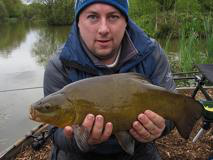

In [18]:
img = PIL.Image.open(img_fn)
img

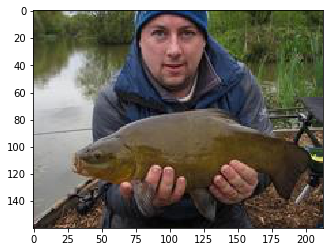

In [19]:
plt.imshow(img)

In [20]:
import numpy 
imga = numpy.array(img)

In [21]:
imga.shape

(160, 213, 3)

In [22]:
imga[:10,:10,0]

array([[ 88,  89,  83,  73, ...,  79,  76,  82,  84],
       [106, 103,  92,  75, ...,  70,  69,  75,  80],
       [105, 103,  94,  79, ...,  73,  77,  76,  78],
       [ 91,  94,  94,  86, ...,  77,  82,  80,  79],
       ...,
       [ 65,  70,  82,  92, ...,  67,  65,  63,  66],
       [ 70,  71,  77,  86, ...,  64,  63,  63,  66],
       [ 61,  62,  70,  82, ...,  64,  59,  59,  64],
       [ 65,  64,  67,  75, ...,  73,  64,  59,  61]], dtype=uint8)

In [32]:
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith('image'))

In [35]:
' '.join(image_extensions)

'.ico .tif .xbm .tiff .jpe .ief .gif .png .pbm .ppm .rgb .pgm .jpg .svg .xpm .pnm .ras .bmp .jpeg .xwd'

In [36]:
def setify(o): return o if isinstance(o, set) else set(listify(o))

In [37]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [38]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs
           if not f.startswith('.')
           and ((not extensions)
                or f".{f.split('.')[-1].lower()}" in extensions)]
    return res

In [51]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00024327.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00007197.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00017700.JPEG')]